# Author Prediction: Unsupervised NLP with BOW
# Introduction

For this project we will be using a dataset of newspaper articles found on Kaggle, taken from a wide variety of news sources. We will choose a subset of text consisting of 200 articles, with 10 different authors. Each author's corpus will contain 20 articles.

https://www.kaggle.com/snapcrack/all-the-news

The goal of this project is to build a model to accurately predict the author of each article. We will utilize unsupervised natural language processing (NLP) with spaCy and the bag-of-words (BOW) method.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import json
from time import time
from collections import Counter
from sklearn import ensemble
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation, SpectralClustering, MeanShift, estimate_bandwidth

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, log_loss, make_scorer, normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize, normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import scikitplot.plotters as skplt

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

stopwords = stopwords.words('english')

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.16.4
Pandas version: 0.23.4
Seaborn version: 0.9.0


# Data Exploration

In [2]:
df = pd.read_csv('datasets/all-the-news/articles1.csv')
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [3]:
df.isnull().sum()

Unnamed: 0         0
id                 0
title              0
publication        0
author          6306
date               0
year               0
month              0
url            50000
content            0
dtype: int64

Let's drop unnecessary columns.

In [4]:
df = df.drop(['Unnamed: 0', 'url'], axis=1)
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


Check for null values.

In [5]:
df.isnull().sum()

id                0
title             0
publication       0
author         6306
date              0
year              0
month             0
content           0
dtype: int64

In [6]:
df = df.dropna()
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


In [7]:
df.isnull().sum()

id             0
title          0
publication    0
author         0
date           0
year           0
month          0
content        0
dtype: int64

Let's take a look at the distribution of article lengths, in characters.

Article Length Statistics
count     43694.000000
mean       3853.685197
std        3894.493670
min           1.000000
25%        1672.000000
50%        2810.500000
75%        5046.750000
max      149346.000000
dtype: float64


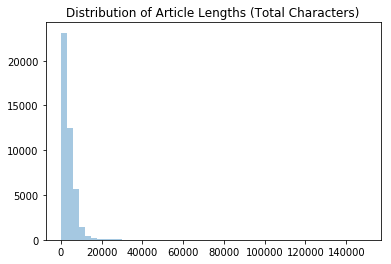

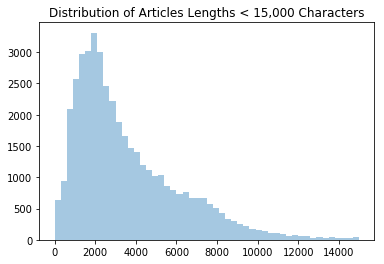

0     5607
1    27834
2    14018
3    12274
4     4195
dtype: int64

In [8]:
lengths = pd.Series([len(x) for x in df.content])
print('Article Length Statistics')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (Total Characters)')
plt.show()

sns.distplot(lengths[lengths < 15000], kde=False)
plt.title('Distribution of Articles Lengths < 15,000 Characters')
plt.show()
lengths.head()

# Data Selection

We will select 10 authors (with 20 articles each) for our overall text corpus, and save it to a DataFrame.

In [9]:
# First 10 authors with more than 20 articles
print(df.author.value_counts()[df.author.value_counts()>20][-10:])

Carl Hulse              21
Ben Shapiro             21
The Associated Press    21
Nicholas Fandos         21
Dennis Green            21
Amanda Jackson          21
Max Fisher              21
Victor Mather           21
Ashley Strickland       21
Patrick Healy           21
Name: author, dtype: int64


In [10]:
# Make a DataFrame with articles by our chosen authors
# Include author names and article titles

# Make a list of the 10 chosen author names
names = df.author.value_counts()[df.author.value_counts() > 20][-10:].index.tolist()

print(names)

# DataFrame for articles of all chosen authors
data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = df[df.author == name][:20][['title', 'content', 'author']]
    # Append data to DataFrame
    data = data.append(articles)

data = data.reset_index().drop('index', 1)

['Carl Hulse', 'Ben Shapiro', 'The Associated Press', 'Nicholas Fandos', 'Dennis Green', 'Amanda Jackson', 'Max Fisher', 'Victor Mather', 'Ashley Strickland', 'Patrick Healy']


Let's make sure we have 200 articles total and 20 articles per author.

In [11]:
# Check for duplicates
print('Total articles:', data.shape[0])
print('Unique articles:', len(np.unique(data.index)))

# Number of authors
print('Unique authors:', len(np.unique(data.author)))
print('')
print('Articles by author:\n')

# Article counts by author
print(data.author.value_counts())

Total articles: 200
Unique articles: 200
Unique authors: 10

Articles by author:

Amanda Jackson          20
Patrick Healy           20
Ben Shapiro             20
Max Fisher              20
Carl Hulse              20
Victor Mather           20
Dennis Green            20
The Associated Press    20
Nicholas Fandos         20
Ashley Strickland       20
Name: author, dtype: int64


# Feature Engineering
Now we can proceed with feature engineering. We will combine each author's set of articles into a separate corpus and run spacy on these documents. 

In [12]:
start_time = time()

# Load spacy NLP object
nlp = spacy.load('en')

# A list to store common words by all authors
common_words = []

# A dictionary to store each author's spacy_doc object
authors_docs = {}

for name in names:
    # Corpus is all text written by a single author
    corpus = ""
    
    # Grab all text of current author, along 'content' column
    author_content = data.loc[data.author == name, 'content']
    
    # Add each article to overall corpus
    for article in author_content:
        corpus = corpus + article
        
    # Clean corpus and parse using Spacy
    doc = nlp(corpus)
    
    # Store doc in dictionary
    authors_docs[name] = doc
        
    # Remove punctuation and stop words
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        
    # Return most common words of that author's corpus
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of common words
    for word in bow:
        common_words.append(word)

# Remove duplicates
common_words = set(common_words)
    
print('Total number of common words:', len(common_words))
print("Completed in %0.3fs" % (time() - start_time))

Total number of common words: 4440
Completed in 37.202s


In [13]:
# Let's see how many words per author
lengths = []
for k,v in authors_docs.items():
    print(k,'corpus has', len(v), ' words.')
    lengths.append(len(v))

Carl Hulse corpus has 22804  words.
Ben Shapiro corpus has 20926  words.
The Associated Press corpus has 10347  words.
Nicholas Fandos corpus has 20684  words.
Dennis Green corpus has 7465  words.
Amanda Jackson corpus has 8971  words.
Max Fisher corpus has 31833  words.
Victor Mather corpus has 15589  words.
Ashley Strickland corpus has 23623  words.
Patrick Healy corpus has 30286  words.


Let's plot a histogram of word counts for each author's corpus.

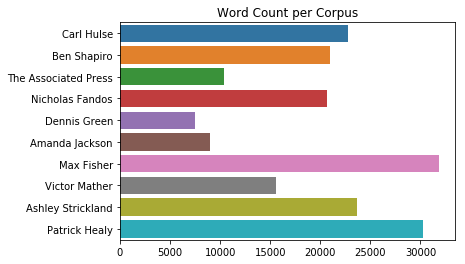

In [14]:
sns.barplot(x=lengths, y=names, orient='h')
plt.title('Word Count per Corpus')
plt.show()

In [15]:
# Check for lowercase words
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Total common words: ', len(common_words))
print('Total lowercase common words: ', np.sum([word.islower() for word in common_words]))

# Make all common words lowercase
common_words = [word.lower() for word in common_words]
print('Total lowercase common words (after converting): ', np.sum([word.islower() for word in common_words]))

Total common words:  4440
Total lowercase common words:  3153
Total lowercase common words (after converting):  4324


In [16]:
# Remove words that might conflict with new features
if 'author' in common_words:
    common_words.remove('author')
if 'title' in common_words:
    common_words.remove('title')
if 'content' in common_words:
    common_words.remove('content')

Now we can create a DataFrame, bow_counts, to store our bag-of-words counts for each article. This section takes the longest amount of time to process; runtime to populate the DataFrame is at least 30 minutes.

In [17]:
# Count how many times a common word appears in each article
bow_counts = pd.DataFrame()
for name in names:
    # Select 20 articles for each author
    articles = data.loc[data.author==name,:][:20]
    # Append articles to BOW dataframe
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# Use common_words as the columns of a temporary DataFrame
df = pd.DataFrame(columns=common_words)

# Join BOW features with the author's content
bow_counts = bow_counts.join(df)

# Initialize rows with zeroes
bow_counts.loc[:,common_words] = 0

# Populate DataFrame with counts of every feature per article
start_time = time()
for i, article in enumerate(bow_counts.content):
    doc = nlp(article)
    for token in doc:
        # If lowercase word is found in common words, increment its BOW count
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
    # Print a message every 20 articles
    if i % 20 == 0:
        if time()-start_time < 3600: # if less than an hour in seconds
            print('Article ', i, ' completed after ', (time()-start_time)/60,' minutes.')
        else:
            print('Article ', i, ' completed after ', (time()-start_time)/60/60,' hours.')

Article  0  completed after  0.12338216702143351  minutes.
Article  20  completed after  3.6388455351193745  minutes.
Article  40  completed after  6.3732951005299885  minutes.
Article  60  completed after  8.130001564820608  minutes.
Article  80  completed after  11.924612931410472  minutes.
Article  100  completed after  13.211512581507366  minutes.
Article  120  completed after  14.73138683239619  minutes.
Article  140  completed after  19.187068514029185  minutes.
Article  160  completed after  21.335653630892434  minutes.
Article  180  completed after  24.357935965061188  minutes.


In [18]:
bow_counts.head(3)

,title,content,author,professor,substitute,floriston,mortar,expand,attempt,symmetry,...,bed,laser,housing,ball,assessment,heat,mccourty,marijuana,speaking,heavy
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,Carl Hulse,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Republicans Stonewalled Obama. Now the Ball Is...,WASHINGTON — It’s or time for Republica...,Carl Hulse,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"In Republicans’ Ethics Office Gambit, a Specta...",WASHINGTON — Majorities in Congress often o...,Carl Hulse,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Set target and features
y = bow_counts['author']
X = bow_counts.drop(['content','author','title'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [20]:
# Store overall results in two separate DataFrames
clust_metrics = ['Algorithm', 'Dataset', 'Sample Size', 'ARI', 'Silhouette']
model_metrics = ['Algorithm', 'ARI', 'Cross-validation', 'Train Accuracy', 'Test Accuracy']

results_clust = pd.DataFrame(columns=clust_metrics)
results_model = pd.DataFrame(columns=model_metrics)

# Clustering
We will evaluate three separate clustering algorithms: K-Means, Mean-shift, and Affinity Propagation. We will do these for the train and test sets, separately. First, we can use the elbow method plot to get a rough idea of the optimal number of clusters for K-Means.
## Find Optimal Clusters

2 clusters
3 clusters
4 clusters
5 clusters
6 clusters
7 clusters
8 clusters
9 clusters
10 clusters
11 clusters
12 clusters
13 clusters
14 clusters
15 clusters
16 clusters
17 clusters
18 clusters
19 clusters
20 clusters


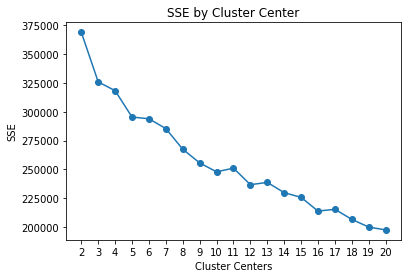

In [21]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=42).fit(data).inertia_)
        print('{} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center')
    
find_optimal_clusters(X_train, 20)

It is difficult to tell where the true elbow lies in the graph above. There appear to be multiple elbows at 8, 11, and 14 clusters. We can use GridSearchCV to help us estimate the optimal parameters for our clustering algorithm, including the optimal number of clusters. Let's create a function to run our clustering algorithms and save the results in a DataFrame. Then we will run this separately for the train and test sets, for each model.

In [22]:
# Function to quickly evaluate clustering solutions
def evaluate_cluster(data, target, clust, params, dataset, i):
    start_time = time()
    print('\n','-'*50,'\n',clust.__class__.__name__,'\n','-'*50)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(adjusted_rand_score)
    search = GridSearchCV(clust, params, scoring=score, cv=5).fit(data, target)
    print("Best parameters:", search.best_params_)
    y_pred = search.best_estimator_.fit_predict(data)

    ari = adjusted_rand_score(target, y_pred)
    results_clust.loc[i, 'ARI'] = ari 
    print("Adjusted Rand-Index: %.3f" % ari)
    
    sil = silhouette_score(data, y_pred)
    results_clust.loc[i, 'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    results_clust.loc[i, 'Algorithm'] = clust.__class__.__name__
    results_clust.loc[i, 'Dataset'] = dataset
    results_clust.loc[i, 'Sample Size'] = len(data)
    
    # Print contingency matrix
    crosstab = pd.crosstab(target, y_pred)
    plt.figure(figsize=(10,5))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.winter)
    plt.show()
    print(time()-start_time, "seconds.")

## Train Set
### K-Means


 -------------------------------------------------- 
 KMeans 
 --------------------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 20, 'n_init': 10, 'precompute_distances': True}
Adjusted Rand-Index: 0.150
Silhouette Score: -0.017


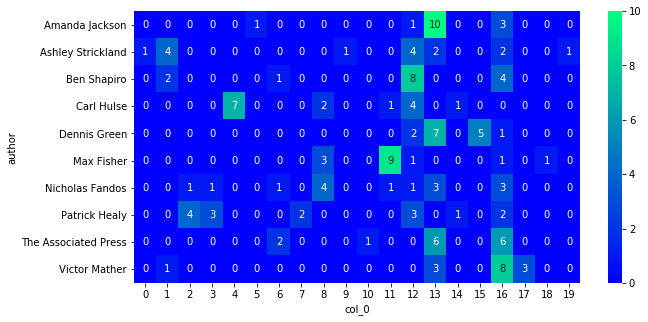

128.82036089897156 seconds.


In [23]:
clust = KMeans()
params={
    'n_clusters': np.arange(5, 30, 5),
    'init': ['k-means++','random'],
    'n_init': [10, 20],
    'precompute_distances':[True, False]
}
evaluate_cluster(X_train, y_train, clust, params, dataset='Train', i=0)

### Mean-shift


 -------------------------------------------------- 
 MeanShift 
 --------------------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.017
Silhouette Score: 0.160


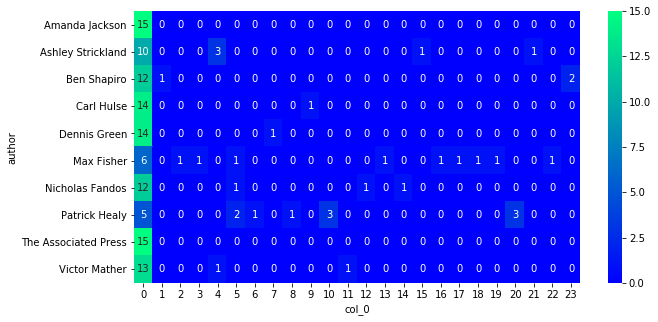

23.06464195251465 seconds.


In [24]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_cluster(X_train, y_train, clust, params, dataset='Train', i=1)

### Affinity Propagation


 -------------------------------------------------- 
 AffinityPropagation 
 --------------------------------------------------
Best parameters: {'damping': 0.5, 'max_iter': 200}
Adjusted Rand-Index: 0.142
Silhouette Score: 0.100


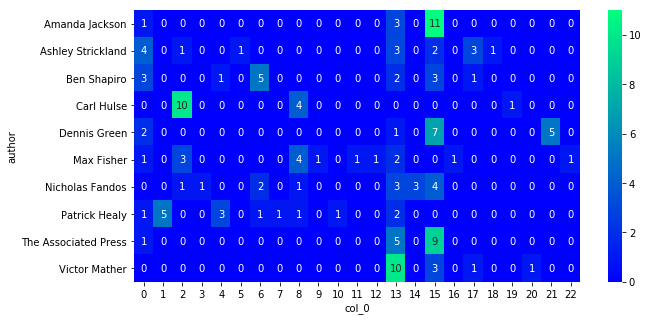

2.343078851699829 seconds.


In [25]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9], 
    'max_iter': [200, 500]
}
evaluate_cluster(X_train, y_train, clust, params, dataset='Train', i=2)

## Test Set
### K-Means


 -------------------------------------------------- 
 KMeans 
 --------------------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 20, 'n_init': 10, 'precompute_distances': False}
Adjusted Rand-Index: 0.107
Silhouette Score: 0.017


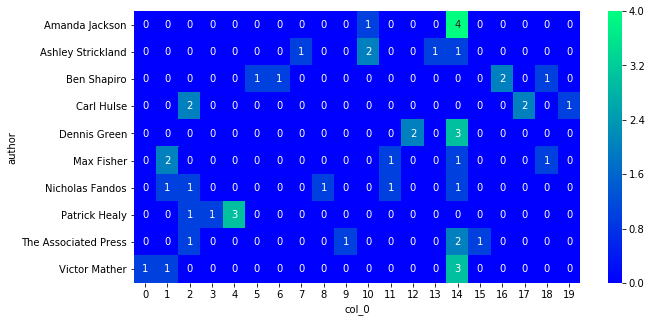

44.16895794868469 seconds.


In [26]:
clust = KMeans()
params={
    'n_clusters': np.arange(5, 30, 5),
    'init': ['k-means++','random'],
    'n_init': [10, 20],
    'precompute_distances':[True, False]
}
evaluate_cluster(X_test, y_test, clust, params, dataset='Test', i=3)

### Mean-shift


 -------------------------------------------------- 
 MeanShift 
 --------------------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.028
Silhouette Score: 0.200


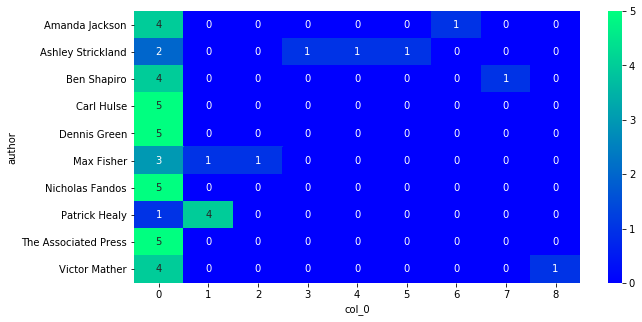

3.139875888824463 seconds.


In [27]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_cluster(X_test, y_test, clust, params, dataset='Test', i=4)

### Affinity Propagation


 -------------------------------------------------- 
 AffinityPropagation 
 --------------------------------------------------
Best parameters: {'damping': 0.9, 'max_iter': 200}
Adjusted Rand-Index: 0.096
Silhouette Score: 0.204


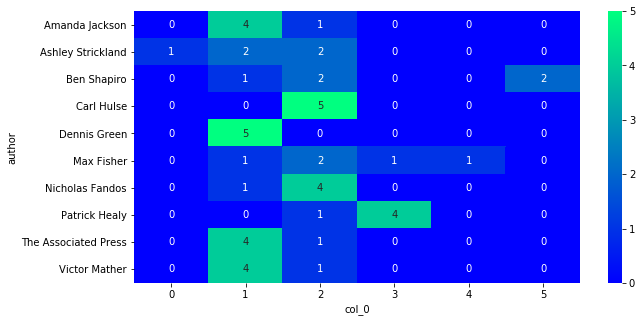

1.1127409934997559 seconds.


In [28]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9], 
    'max_iter': [200, 500]
}
evaluate_cluster(X_test, y_test, clust, params, dataset='Test', i=5)

In [29]:
results_clust.iloc[:6].sort_values('ARI', ascending=False)

,Algorithm,Dataset,Sample Size,ARI,Silhouette
0,KMeans,Train,150,0.149814,-0.0169088
2,AffinityPropagation,Train,150,0.141887,0.0995564
3,KMeans,Test,50,0.106672,0.0168389
5,AffinityPropagation,Test,50,0.0955434,0.204466
4,MeanShift,Test,50,0.0281253,0.199844
1,MeanShift,Train,150,0.0168168,0.160355


Our two best clustering solutions were K-Means, according to the ARI score. In fact, running K-Means on our test set gave us the highest ARI score. However, we are likely to get much higher ARI scores just from using supervised learning models. We can run one modeling iteration without a clustering feature added in, and then do another iteration with a clustering feature to indicate which cluster an article belongs to.

# Modeling
We can create a simple function to run our model and store results in a dataframe, which will allow us to easily compare results at the end.

In [30]:
def evaluate_model(clf, params, features, i):
    start_time = time()
    
    # Print classifier type
    print('\n', '-'*50, '\n', clf.__class__.__name__, '\n', '-'*50)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(adjusted_rand_score)
    search = GridSearchCV(clf, params, scoring=score, cv=5).fit(X, y)
    
    # Extract best estimator
    best = search.best_estimator_
    print("Best parameters:", search.best_params_)

    # Run cross-validation
    cv = cross_val_score(X=X, y=y,estimator=best, cv=5)
    print("\nCross-validation scores:", cv)
    print("\nMean cross-validation score:", cv.mean())
    results_model.loc[i, 'Cross-validation'] = cv.mean() 
    
    # Calculate training accuracy
    best = best.fit(X_train, y_train)
    train = best.score(X=X_train,y=y_train)
    results_model.loc[i, 'Train Accuracy'] = train 
    print("\nTrain Set Accuracy Score:", train)

    # Calculate test accuracy
    test = best.score(X=X_test, y=y_test)
    results_model.loc[i, 'Test Accuracy'] = test 
    print("\nTest Set Accuracy Score:", test)
    
    y_pred = best.predict(X_test)

    ari = adjusted_rand_score(y_test, y_pred)
    results_model.loc[i, 'ARI'] = ari 
    print("\nAdjusted Rand-Index: %.3f" % ari)
    
    print(classification_report(y_test, y_pred))

    conf_matrix = pd.crosstab(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.winter)
    plt.show()
    
    results_model.loc[i,'Data Size'] = len(X)
    results_model.loc[i,'Features'] = features
    results_model.loc[i,'Algorithm'] = clf.__class__.__name__
    print(time()-start_time, 'seconds.')

## Iteration 1: BoW Features
### Logistic Regression


 -------------------------------------------------- 
 LogisticRegression 
 --------------------------------------------------
Best parameters: {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-validation scores: [0.8   0.8   0.8   0.825 0.7  ]

Mean cross-validation score: 0.7850000000000001

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.82

Adjusted Rand-Index: 0.674
                      precision    recall  f1-score   support

      Amanda Jackson       0.67      0.80      0.73         5
   Ashley Strickland       0.80      0.80      0.80         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       1.00      1.00      1.00         5
        Dennis Green       1.00      1.00      1.00         5
          Max Fisher       1.00      1.00      1.00         5
     Nicholas Fandos       0.67      0.80      0.73         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.50      0.20      0.

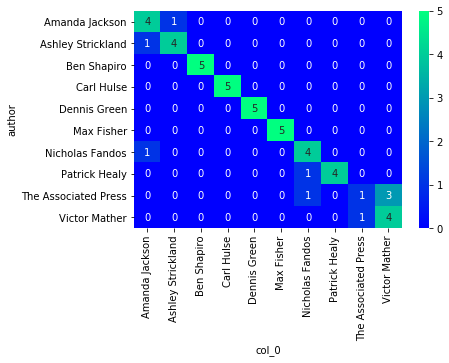

490.68394708633423 seconds.


In [31]:
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear', 'saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1', 'l2']
}]

clf = LogisticRegression(
    n_jobs=-1, # Use all CPU
    multi_class='auto'
)

evaluate_model(clf=clf, params=params, features='BOW', i=0)

### Random Forest Classifier


 -------------------------------------------------- 
 RandomForestClassifier 
 --------------------------------------------------
Best parameters: {'n_estimators': 20}

Cross-validation scores: [0.75  0.775 0.8   0.7   0.675]

Mean cross-validation score: 0.74

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.74

Adjusted Rand-Index: 0.513
                      precision    recall  f1-score   support

      Amanda Jackson       1.00      0.40      0.57         5
   Ashley Strickland       0.83      1.00      0.91         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       0.71      1.00      0.83         5
        Dennis Green       0.50      1.00      0.67         5
          Max Fisher       0.67      0.80      0.73         5
     Nicholas Fandos       0.67      0.40      0.50         5
       Patrick Healy       1.00      1.00      1.00         5
The Associated Press       0.67      0.40      0.50         5
       Victor Mather       

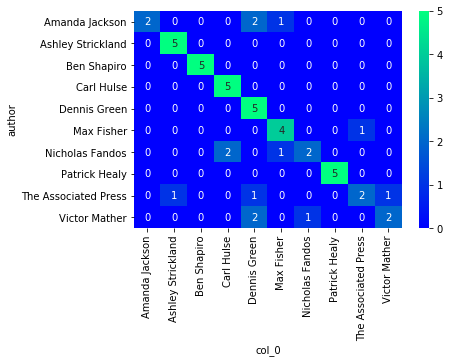

6.2545857429504395 seconds.


In [32]:
params = [{
    'n_estimators': [10, 15, 20]
}]

clf = RandomForestClassifier(
    n_jobs=-1 # Use all CPU
)

evaluate_model(clf=clf, params=params, features='BOW', i=1)

### Gradient Boosting Classifier


 -------------------------------------------------- 
 GradientBoostingClassifier 
 --------------------------------------------------
Best parameters: {'max_depth': 2, 'n_estimators': 200}

Cross-validation scores: [0.775 0.725 0.825 0.675 0.8  ]

Mean cross-validation score: 0.76

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.88

Adjusted Rand-Index: 0.732
                      precision    recall  f1-score   support

      Amanda Jackson       1.00      0.80      0.89         5
   Ashley Strickland       0.83      1.00      0.91         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       1.00      0.80      0.89         5
        Dennis Green       0.83      1.00      0.91         5
          Max Fisher       1.00      1.00      1.00         5
     Nicholas Fandos       0.83      1.00      0.91         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.62      1.00      0.77         5
      

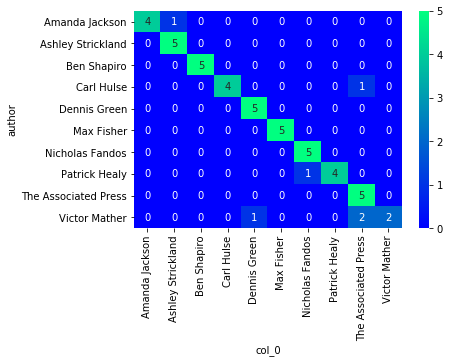

532.0966258049011 seconds.


In [33]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = [{
    'n_estimators': [200, 500],
    'max_depth': [2, 3, 4, 5]
}]

clf = ensemble.GradientBoostingClassifier()

evaluate_model(clf=clf, params=params, features='BOW', i=2)

## Iteration 2: BoW Features with Clustering Assignment
Let's compute our clusters using K-Means with the optimal set of parameters determined above. Then we can add this as another feature to our original dataset.

In [34]:
# Calculate predicted values.
clusters_train = KMeans(init='random', n_clusters=15, n_init=20, precompute_distances=False).fit_predict(X_train)
clusters_test = KMeans(init='k-means++', n_clusters=25, n_init=10, precompute_distances=False).fit_predict(X_test)
print(clusters_train)
print(clusters_test)

[ 9  5  5  9 14 13  9  1  1  3  1 12  0 13 10 10  9 13  1 13 13  0  0 11
 14  9  1  1  9  9  8  1  0  5  1  5  5  0  5  0  7  0 10  0 13  9  0  5
 11  1  1 14 14  7  3  1  9  0  1 10 10 10  0  1  2  0 10  9  0  2  0  0
  0 14  9 14  1 14  9  0  9  9  1  5 13  0  9  1  1  9  9  1 10  0  0 14
  4  9 11  9 10  9  5  1 11  1  0 11  9 13  5 14 13  8  0  1 10 10 10  9
 10  3  3  6 10  2 10  9  0  0  0 10  9 13  9  9 13  0 11 11 11 10  0  0
  9  3 10  9 13 13]
[23 23 23  0  7 20  2 23 23  5 18  6 10 23 11 22 19  6  6  3 23  1  6  9
  2  2  2 23 12 21  2 23 24 13 21 23 23 16  2  2 17 10  8  4 23  6 15 16
  2 14]


In [35]:
X_train['cluster_assignment'] = list(clusters_train)
X_train.head()

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,professor,substitute,floriston,mortar,expand,attempt,symmetry,36,escape,pass,...,laser,housing,ball,assessment,heat,mccourty,marijuana,speaking,heavy,cluster_assignment
150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
171,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14


In [36]:
X_test['cluster_assignment'] = list(clusters_test)
X_test.head()

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,professor,substitute,floriston,mortar,expand,attempt,symmetry,36,escape,pass,...,laser,housing,ball,assessment,heat,mccourty,marijuana,speaking,heavy,cluster_assignment
153,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,23
92,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,23
80,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
73,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
165,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


### Logistic Regression


 -------------------------------------------------- 
 LogisticRegression 
 --------------------------------------------------
Best parameters: {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-validation scores: [0.8   0.8   0.8   0.825 0.7  ]

Mean cross-validation score: 0.7850000000000001

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.72

Adjusted Rand-Index: 0.516
                      precision    recall  f1-score   support

      Amanda Jackson       0.25      0.20      0.22         5
   Ashley Strickland       0.80      0.80      0.80         5
         Ben Shapiro       0.83      1.00      0.91         5
          Carl Hulse       1.00      0.80      0.89         5
        Dennis Green       1.00      1.00      1.00         5
          Max Fisher       1.00      0.80      0.89         5
     Nicholas Fandos       0.50      0.60      0.55         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.40      0.40      0.

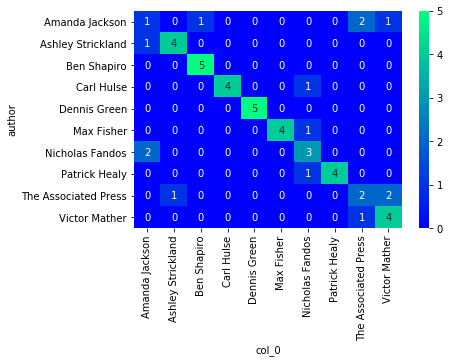

475.6625771522522 seconds.


In [37]:
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear', 'saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1', 'l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

evaluate_model(clf=clf, params=params, features='BOW & Clust', i=3)

### Random Forest Classifier


 -------------------------------------------------- 
 RandomForestClassifier 
 --------------------------------------------------
Best parameters: {'n_estimators': 20}

Cross-validation scores: [0.725 0.675 0.75  0.725 0.65 ]

Mean cross-validation score: 0.705

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.74

Adjusted Rand-Index: 0.573
                      precision    recall  f1-score   support

      Amanda Jackson       0.67      0.80      0.73         5
   Ashley Strickland       0.75      0.60      0.67         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       0.62      1.00      0.77         5
        Dennis Green       0.71      1.00      0.83         5
          Max Fisher       0.71      1.00      0.83         5
     Nicholas Fandos       1.00      0.20      0.33         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.00      0.00      0.00         5
       Victor Mather      

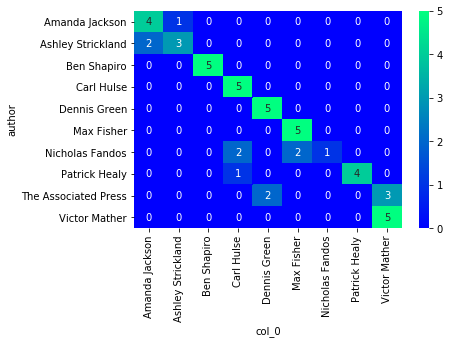

7.328387975692749 seconds.


In [38]:
params = [{
    'n_estimators': [10, 15, 20]
}]

clf = RandomForestClassifier(
    n_jobs=-1 # Use all CPU
)

evaluate_model(clf=clf, params=params, features='BOW & Clust', i=4)

### Gradient Boosting Classifier


 -------------------------------------------------- 
 GradientBoostingClassifier 
 --------------------------------------------------
Best parameters: {'max_depth': 2, 'n_estimators': 500}

Cross-validation scores: [0.75  0.75  0.85  0.725 0.775]

Mean cross-validation score: 0.77

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.86

Adjusted Rand-Index: 0.689
                      precision    recall  f1-score   support

      Amanda Jackson       1.00      0.80      0.89         5
   Ashley Strickland       0.83      1.00      0.91         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       1.00      0.60      0.75         5
        Dennis Green       0.83      1.00      0.91         5
          Max Fisher       1.00      1.00      1.00         5
     Nicholas Fandos       0.71      1.00      0.83         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.62      1.00      0.77         5
      

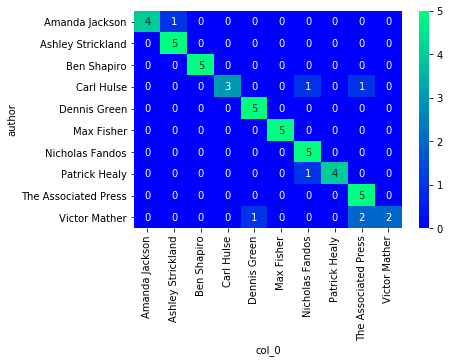

510.4360148906708 seconds.


In [39]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = [{
    'n_estimators': [200, 500],
    'max_depth': [2, 3, 4, 5]
}]

clf = ensemble.GradientBoostingClassifier()

evaluate_model(clf=clf, params=params, features='BOW & Clust', i=5)

In [40]:
results_model.iloc[:6].sort_values('ARI', ascending=False)

,Algorithm,ARI,Cross-validation,Train Accuracy,Test Accuracy,Data Size,Features
2,GradientBoostingClassifier,0.731563,0.76,1.0,0.88,200.0,BOW
5,GradientBoostingClassifier,0.689132,0.77,1.0,0.86,200.0,BOW & Clust
0,LogisticRegression,0.674314,0.785,1.0,0.82,200.0,BOW
4,RandomForestClassifier,0.572688,0.705,1.0,0.74,200.0,BOW & Clust
3,LogisticRegression,0.515589,0.785,1.0,0.72,200.0,BOW & Clust
1,RandomForestClassifier,0.513213,0.74,1.0,0.74,200.0,BOW


# Conclusion

Logistic Regression with the 'BOW & Clust' set of features was our best model, obtaining the highest ARI score at 0.72 as well as the highest test set accuracy score of 0.86. Gradient Boosting Classifier with the 'BOW & Clust' features wasn't too far behind with an ARI of 0.68 and test set accuracy score of 0.86. Most notably, our two best models were those using the clustering assignment feature added in. Interestingly, our train set accuracy was 1.0 for every model. Though not ideal, this result is predictable due to the sample size being only 200 articles; it indicates overfitting.

Unfortunately, adding the clustering feature didn't fix the overfitting, although it did increase our test set accuracy by 0.04, which is sizable. A much larger sample size and perhaps more rigorous feature engineering is needed to get a more realistic train set accuracy score, although our test set accuracy scores are already reasonable enough. The dropoff from train set accuracy to test set accuracy is not terribly steep, so this is likely just a sample size issue. Due to the intensive nature of NLP, increasing the sample size of articles used even by a small amount may greatly increase the preprocessing time, which already takes about an hour.